# exploring death data from the US CDC

- not interested in the details?  skip to the bottom for the latest graph.
- motivation
    - https://www.businessinsider.com/yale-study-excess-deaths-nearly-twice-official-covid-19-count-2020-4?op=1
        - excess deaths exceed deaths officially attributed to covid, in US and elsewhere.
        - reliant on figures from the National Center for Health Statistics (part of the CDC).
        - at a time when traffic fatalities were in steep decline due to stay-at-home orders.
    - here we exclude traffic fatalities, overdoses, suicides, etc by looking only at deaths from natural causes.
    - note that here we ignore specific cause of death, as long as it's a natural cause.
        - these are not just the official covid deaths, but all natural deaths.
- comparisons
    - https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm
        - 13 "dashboards" but none show the undercount directly
        - at best they show the undercount as part of total deaths, but not as compared w the number of deaths attributed to covid
    - https://coronavirus.jhu.edu/
        - no 'official' vs excess deaths
- data sources
    - mmwr = Morbidity and Mortality Weekly Report
    - baseline 2014-2018
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr
            - json format:  https://data.cdc.gov/resource/3yf8-kanr.json
                - throttled unless you get an app token.
            - pandas format:  https://dev.socrata.com/foundry/data.cdc.gov/3yf8-kanr
                - no app token needed.
    - current 2019-ongoing
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
        - updated every Thursday to the week_ending_date (always a Saturday) 12 days earlier.
- background
    - Timeliness of Death Certificate Data  https://www.cdc.gov/nchs/data/vsrr/report001.pdf
        - timeliness seems to have improved since this 2015 article, but the delay remains an issue.
    - note that 52 weeks X 7 days per week = just 364 days, so each year has an extra day (or two for leap years); thus there is a 53-mmwrweek year every 5-6 years.
    - 2014 is the most recent 53-mmwrweek year.

In [17]:
# external dependencies

import pandas as pd
import matplotlib.pyplot as plt

# to install sodapy, at commandline: pip install sodapy
from sodapy import Socrata


In [18]:
# data loading details

# here we save the downloaded file for reuse to reduce bandwidth;
# and besides: "Requests made without an app_token will be subject to strict throttling limits."

from os import makedirs
from os.path import join, exists
from pickle import load

data_code_by_dataset = dict(
    current='muzy-jte6',
    baseline='3yf8-kanr',
)


def download_data(data_code, data_path):
    app_token = None  # no token needed for public datasets downloaded via Socrata.
    client = Socrata("data.cdc.gov", app_token)
    data = list(client.get_all(data_code))
    
    # write data to local file
    from pickle import dump
    with open(data_path, 'wb') as f:
        dump(data, f)
        
    return data

def read_local_data(data_path):
    with open(data_path, 'rb') as f:
        data = load(f)
    return data

def read_data(dataset_name):
    data_dir = 'data'
    fname = dataset_name + '.pickl'
    fpath = join(data_dir, fname)
    if not exists(data_dir):
        makedirs(data_dir)
    if exists(fpath):
        return read_local_data(fpath)
    else:
        data_code = data_code_by_dataset[dataset_name]
        return download_data(data_code, fpath)

In [19]:
# load the 2019-2020 "current" dataset (updated weekly)

data = read_data('current')
print(f'\nThe 2019-2020 dataset is {len(data)} rows, {2 * 52 * 54 - len(data)} rows short of 2 years X 52 weeks per year X 54 locations = {2 * 52 * 54} rows; the first row is:\n')
display(data[0])


The 2019-2020 dataset is 5454 rows, 162 rows short of 2 years X 52 weeks per year X 54 locations = 5616 rows; the first row is:



{'jurisdiction_of_occurrence': 'Alabama',
 'mmwryear': '2019',
 'mmwrweek': '1',
 'week_ending_date': '2019-01-05',
 'all_cause': '1077',
 'natural_cause': '993',
 'septicemia_a40_a41': '30',
 'malignant_neoplasms_c00_c97': '198',
 'diabetes_mellitus_e10_e14': '22',
 'alzheimer_disease_g30': '60',
 'influenza_and_pneumonia_j09_j18': '21',
 'chronic_lower_respiratory': '63',
 'other_diseases_of_respiratory': '14',
 'nephritis_nephrotic_syndrome': '21',
 'symptoms_signs_and_abnormal': '27',
 'diseases_of_heart_i00_i09': '261',
 'cerebrovascular_diseases': '53',
 'covid_19_u071_multiple_cause_of_death': '0',
 'covid_19_u071_underlying_cause_of_death': '0'}

In [20]:
# create the 2019-2020 dataframe
current_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')
latest_mmwryear = current_df.mmwryear.max()
latest_mmwrweek = current_df.query(f'mmwryear == {latest_mmwryear}').mmwrweek.max()
latest_week_ending_date = current_df.query(f'mmwryear == {latest_mmwryear} and mmwrweek == {latest_mmwrweek}').week_ending_date.unique()[0]
display(f"latest mmwryear is {latest_mmwryear}")
display(f"latest mmwrweek is {latest_mmwrweek}")
display(f"latest week_ending_date is {latest_week_ending_date}")
#display(w.jurisdiction_of_occurrence.unique())
mmwrweek_and_week_ending_date = current_df.query(f"mmwryear == {latest_mmwryear} and jurisdiction_of_occurrence == 'United States'")
mmwrweek_to_week_ending_date = dict(zip(mmwrweek_and_week_ending_date.mmwrweek, mmwrweek_and_week_ending_date.week_ending_date))
display(current_df)

'latest mmwryear is 2020'

'latest mmwrweek is 49'

'latest week_ending_date is 2020-12-05'

,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,...,flag_cov19ucod,flag_sept,flag_diab,flag_alz,flag_clrd,flag_stroke,flag_hd,flag_neopl,flag_allcause,flag_natcause
0,Alabama,2019,1,2019-01-05,1077.0,993.0,30.0,198.0,22.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2019,2,2019-01-12,1090.0,994.0,25.0,187.0,24.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2019,3,2019-01-19,1114.0,1042.0,22.0,238.0,18.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2019,4,2019-01-26,1063.0,994.0,21.0,165.0,22.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2019,5,2019-02-02,1095.0,1026.0,18.0,199.0,19.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5449,United States,2020,45,2020-11-07,61888.0,58383.0,699.0,11049.0,1760.0,2497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5450,United States,2020,46,2020-11-14,61902.0,58743.0,707.0,10809.0,1735.0,2540.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5451,United States,2020,47,2020-11-21,60951.0,58278.0,660.0,10303.0,1731.0,2399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5452,United States,2020,48,2020-11-28,55185.0,53034.0,589.0,9183.0,1504.0,2259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# combine with baseline death data 2014-2018

data = read_data('baseline')
print(f'\nbaseline has {len(data)} rows')
baseline_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')
yr_min, yr_max = baseline_df.mmwryear.min(), baseline_df.mmwryear.max()
n_yrs = yr_max - yr_min + 1
n_locs = len(baseline_df.jurisdiction_of_occurrence.unique())
print(f'compare with {n_yrs} years X 52 weeks/year * {n_locs} locations =  {n_yrs * 52 * n_locs}')
print(f'thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years\n')

# align column names with latest weekly dataset, for concatenation below
baseline_df = baseline_df.rename(columns=dict(
    weekendingdate="week_ending_date",
    allcause="all_cause",
    naturalcause="natural_cause",
))

display(baseline_df)


baseline has 14094 rows
compare with 5 years X 52 weeks/year * 54 locations =  14040
thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years



,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,malignant_neoplasms_c00_c97,alzheimer_disease_g30,chronic_lower_respiratory,symptoms_signs_and_abnormal,...,diabetes_mellitus_e10_e14,influenza_and_pneumonia_j10,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,flag_clrd,flag_otherunk,flag_stroke,flag_alz,flag_hd,flag_neopl
0,Alabama,2014,1,2014-01-04T00:00:00.000,355,327,60.0,10.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2014,2,2014-01-11T00:00:00.000,872,792,163.0,35.0,61.0,25.0,...,23.0,32.0,14.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2014,3,2014-01-18T00:00:00.000,1044,971,209.0,31.0,77.0,19.0,...,34.0,33.0,19.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2014,4,2014-01-25T00:00:00.000,1022,967,205.0,25.0,74.0,35.0,...,23.0,42.0,16.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2014,5,2014-02-01T00:00:00.000,1040,953,200.0,38.0,68.0,24.0,...,26.0,26.0,15.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089,United States,2018,48,2018-12-01T00:00:00.000,55210,50797,11405.0,2385.0,3028.0,699.0,...,1725.0,908.0,826.0,1071.0,NaN,NaN,NaN,NaN,NaN,NaN
14090,United States,2018,49,2018-12-08T00:00:00.000,56095,51413,11715.0,2469.0,3017.0,678.0,...,1769.0,962.0,883.0,1053.0,NaN,NaN,NaN,NaN,NaN,NaN
14091,United States,2018,50,2018-12-15T00:00:00.000,56530,52053,11917.0,2508.0,3095.0,665.0,...,1665.0,976.0,862.0,1080.0,NaN,NaN,NaN,NaN,NaN,NaN
14092,United States,2018,51,2018-12-22T00:00:00.000,56689,52035,11753.0,2501.0,3139.0,691.0,...,1754.0,1003.0,913.0,1044.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
all_data = pd.concat([baseline_df, current_df])
loc = 'United States'
count_str = 'natural_cause'
loc_data_raw = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
print(f'\ndata from 2014 thru the present totals {len(loc_data_raw)} rows, which is almost 7 years X 52 weeks per year = {7 * 52} weeks (2014 was a 53-mmwrweek year)\n')


data from 2014 thru the present totals 362 rows, which is almost 7 years X 52 weeks per year = 364 weeks (2014 was a 53-mmwrweek year)



In [23]:
count_by_yr = pd.DataFrame({
    yr: pd.Series(
        loc_data_raw.query(f"mmwryear == %d" % yr)[count_str].values,
        index=loc_data_raw.query(f"mmwryear == %d" % yr).mmwrweek
    )
    for yr in range(2014, 2020+1)
})
print(f'\n{len(count_by_yr)} rows (because 2014 was a 53-mmwrweek year)\n')
#display('years included: ' + ' '.join(str(yr) for yr in count_by_yr.columns))
display(count_by_yr)


53 rows (because 2014 was a 53-mmwrweek year)



,2014,2015,2016,2017,2018,2019,2020
mmwrweek,,,,,,,
1,28636.0,57736.0,51769.0,54964.0,61146.0,53577.0,55014.0
2,51827.0,57143.0,51478.0,56325.0,62704.0,53765.0,55742.0
3,50947.0,54694.0,51263.0,54765.0,60193.0,53807.0,54518.0
4,50503.0,53516.0,51492.0,53451.0,58136.0,53525.0,54399.0
5,50370.0,53279.0,50670.0,53828.0,56384.0,53658.0,54008.0
6,49778.0,52592.0,50907.0,54318.0,56498.0,53737.0,54342.0
7,50175.0,52443.0,51559.0,54045.0,55304.0,53511.0,53975.0
8,48991.0,51862.0,50718.0,53838.0,53353.0,53569.0,53988.0
9,47883.0,51720.0,51580.0,52555.0,52183.0,53276.0,54292.0


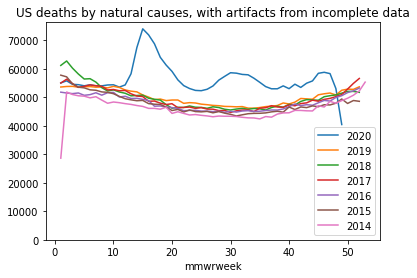

In [24]:
# plot data by year

def plot_df(df, title):
    plt.title(title)
    ax = plt.gca()
        # gca stands for 'get current axes'

    # reverse columns so that legend better corresponds to location of data [2020 is uppermost]
    for yr in reversed(df.columns):
        df[yr].plot(kind='line',x='mmwrweek', y='natural_cause', ax=ax)
    
    # set y-axis to start at zero
    ax.set_ylim(bottom=0)
    ax.legend(loc='lower right')
    
    plt.show()

plot_df(count_by_yr, 'US deaths by natural causes, with artifacts from incomplete data')

In [25]:
from itertools import takewhile

# data from a forthcoming notebook, computed from multiple "current" weekly datasets
undercount_from_latest = [0.5092, 0.1750, 0.0845, 0.0469, 0.0283, 0.0177, 0.0119, 0.0081, 0.0057, 0.0037, 0.0008]

def n_weeks_to_ignore_for_max_undercount(max_undercount):
    return len(list(takewhile((lambda x: x > max_undercount), undercount_from_latest)))



ignoring the last 4 points to avoid an undercount of more than 3.0%



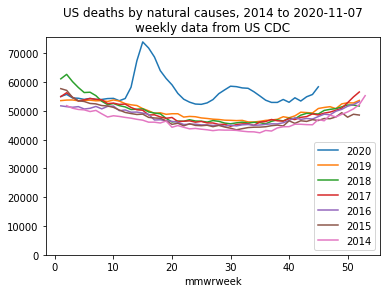


(2017-18 was an unusually bad flu season)


In [26]:
# scrub the data in two steps:

# 1. remove first point in 2014 because it represents only wed-sat of that week [2014 started on a wednesday]
count_by_yr[2014][1] = None

# 2. remove the last few points of the current year because reporting is not yet complete.
max_undercount = .03   # let's go back far enough to avoid undercounting by more than 3%
n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
print(f'\nignoring the last {n_most_recent_points_to_remove} points to avoid an undercount of more than {100 * max_undercount}%\n')
first_point_to_remove = latest_mmwrweek - n_most_recent_points_to_remove + 1
for i in range(first_point_to_remove, first_point_to_remove + n_most_recent_points_to_remove):
    count_by_yr[latest_mmwryear][i] = None

# final plot of the scrubbed data
    
latest_mmwrweek_displayed = first_point_to_remove - 1
latest_week_ending_date_displayed = mmwrweek_to_week_ending_date[latest_mmwrweek_displayed]
plot_df(count_by_yr, f'US deaths by natural causes, 2014 to {latest_week_ending_date_displayed}\nweekly data from US CDC')
print('\n(2017-18 was an unusually bad flu season)')

# next steps

- define excess deaths
- explore excess deaths by state/region
- derive undercount_from_latest (a result used above), and correct for it
- compute heat map over time